# Никитин Роман ПИ18-2
Данные взяты из kaggle https://www.kaggle.com/brittabettendorf/berlin-airbnb-data?select=listings_summary.csv
Данные об аренде жилплощади на airbnb (Берлин). Буду решать задачу регрессии.

Импортируем нужные нам библиотеки

In [77]:
import pandas as pd
import time
import numpy as np
from geopy.distance import great_circle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

Подгружаем данные и проводим первичный осмотр

In [2]:
df_initial = pd.read_csv('listings_summary.csv')

print("The dataset has {} rows and {} columns.".format(*df_initial.shape))

print("It contains {} duplicates.".format(df_initial.duplicated().sum()))

The dataset has 22552 rows and 96 columns.
It contains 0 duplicates.


In [3]:
print(df_initial.head(5))

     id                        listing_url       scrape_id last_scraped  \
0  2015  https://www.airbnb.com/rooms/2015  20181107122246   2018-11-07   
1  2695  https://www.airbnb.com/rooms/2695  20181107122246   2018-11-07   
2  3176  https://www.airbnb.com/rooms/3176  20181107122246   2018-11-07   
3  3309  https://www.airbnb.com/rooms/3309  20181107122246   2018-11-07   
4  7071  https://www.airbnb.com/rooms/7071  20181107122246   2018-11-07   

                                               name  \
0  Berlin-Mitte Value! Quiet courtyard/very central   
1                Prenzlauer Berg close to Mauerpark   
2                   Fabulous Flat in great Location   
3                 BerlinSpot Schöneberg near KaDeWe   
4                  BrightRoom with sunny greenview!   

                                             summary  \
0  Great location!  30 of 75 sq meters. This wood...   
1                                                NaN   
2  This beautiful first floor apartment  is situa.

In [4]:
print(df_initial.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

Колонок ну больно много, большинство из них мне либо не понятны, либо не нужны. К сожалению, нет детального описания каждой колонки, но тем не менее 90% названий сполна объясняют свое содержимое. Обратился за помощью к выложенному в открытый доступ notebook'у, чтобы было проще определиться с колонками, которые отбираю для дальнейшей работы. https://www.kaggle.com/brittabettendorf/predicting-prices-xgboost-feature-engineering/notebook

In [5]:
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_initial[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

The dataset has 22552 rows and 23 columns - after dropping irrelevant columns.


In [6]:
df_raw.head(5)

,space,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,square_feet,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
id,,,,,,,,,,,,,,,,,,,,,
2015,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,...,NaN,$60.00,$30.00,$200.00,$28.00,1,4,f,f,strict_14_with_grace_period
2695,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,...,NaN,$17.00,$0.00,$0.00,$0.00,1,2,f,f,flexible
3176,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,t,Pankow,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,...,720.0,$90.00,$50.00,$200.00,$20.00,2,62,t,f,strict_14_with_grace_period
3309,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,t,Tempelhof - Schöneberg,52.498855,13.349065,Apartment,Private room,2,1.0,...,0.0,$26.00,$30.00,$250.00,$18.00,1,5,f,f,strict_14_with_grace_period
7071,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,t,Pankow,52.543157,13.415091,Apartment,Private room,2,1.0,...,NaN,$42.00,$0.00,$0.00,$24.00,1,2,f,f,moderate


In [7]:
print(df_raw.price.isna().sum(),
df_raw.cleaning_fee.isna().sum(),
df_raw.security_deposit.isna().sum())

0 7146 9361


Замечательно то, что в нашей целевой (в будущем) переменной нет пропущенных значений. Что касается остальных- можем считать, что вместо NA там нули, так как бОльшую часть из непропущенных данных составляют нули. Будем считать, что если человек не указал- значит имел в виду 0. Можно было бы и построить модель, предсказывающую пропущенное значение, возможно займусь этим позже и сравню результаты моделей, обученных на разных данных.

In [8]:
df_raw.cleaning_fee.value_counts()

$0.00      1865
$20.00     1812
$10.00     1633
$30.00     1530
$15.00     1423
           ... 
$210.00       1
$119.00       1
$135.00       1
$66.00        1
$84.00        1
Name: cleaning_fee, Length: 112, dtype: int64

In [9]:
df_raw.security_deposit.value_counts()

$0.00      5319
$100.00    1716
$200.00    1425
$150.00     864
$500.00     817
           ... 
$96.00        1
$690.00       1
$263.00       1
$112.00       1
$127.00       1
Name: security_deposit, Length: 142, dtype: int64

In [10]:
df_raw.cleaning_fee.fillna('$0.00', inplace=True)
df_raw.security_deposit.fillna('$0.00', inplace=True)
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

In [11]:
df_raw.head(5)

,space,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,square_feet,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
id,,,,,,,,,,,,,,,,,,,,,
2015,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,...,NaN,60.0,30.0,200.0,28.0,1,4,f,f,strict_14_with_grace_period
2695,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,...,NaN,17.0,0.0,0.0,0.0,1,2,f,f,flexible
3176,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,t,Pankow,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,...,720.0,90.0,50.0,200.0,20.0,2,62,t,f,strict_14_with_grace_period
3309,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,t,Tempelhof - Schöneberg,52.498855,13.349065,Apartment,Private room,2,1.0,...,0.0,26.0,30.0,250.0,18.0,1,5,f,f,strict_14_with_grace_period
7071,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,t,Pankow,52.543157,13.415091,Apartment,Private room,2,1.0,...,NaN,42.0,0.0,0.0,24.0,1,2,f,f,moderate


Целевая переменная- цена за ренду в долларах. (я убрал знаки доллара в шаге выше.)

In [12]:
df_raw['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

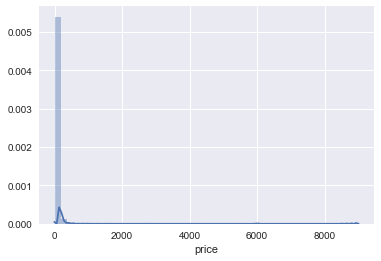

In [13]:
sns_plot = sns.distplot(df_raw['price'])
fig = sns_plot.get_figure()

Как мы видим, в большинстве своем цена за аренду лежит на промежутке от 0 до 100 долларов.

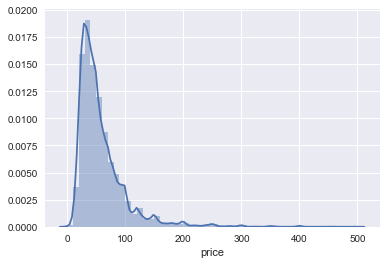

In [14]:
sns_plot = sns.distplot(df_raw['price'][df_raw['price']<500])
fig = sns_plot.get_figure()

75% цен лежат на промежутке от 0 до 70 долларов. Так же есть и "выбросы", когда цены за аренду достигают 9000 долларов. Для модели такие показатели будут существенными "загрязнителями", ибо недвижимость в таких случаях больно элитная, а подобных наблюдений слишком мало. Принял решение ограничиться 400 долларами за аренду, а все остальное- удалить из выборки. Так же удалю и наблюдения, в которых цена 0 долларов.

In [15]:
df_raw.drop(df_raw[ (df_raw.price > 400) | (df_raw.price == 0) ].index, axis=0, inplace=True)

Проверяю, какие еще колонки с пропущенными данными я имею.

In [16]:
df_raw.isna().sum()

space                            8503
description                       202
host_has_profile_pic               25
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          32
bedrooms                           18
bed_type                            0
amenities                           0
square_feet                     21996
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

Чтобы не работать с тексотом- оставляю от описания лишь количество слов в описании. (нагло подсмотрел и украл код из notebook'a выше)

In [17]:
df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_raw['size'] = df_raw['size'].str.replace("\D", "")

df_raw['size'] = df_raw['size'].astype(float)

print('NaNs in size_column absolute:     ', df_raw['size'].isna().sum())
print('NaNs in size_column in percentage:', round(df_raw['size'].isna().sum()/len(df_raw),3)*100, '%')

NaNs in size_column absolute:      11744
NaNs in size_column in percentage: 52.300000000000004 %


Удаляю колонки 'square_feet', 'space','description' так как считаю, что проще будет без них, нежели пытаться заполнить их какими- либо значениями. Так же удаляю наблюдения, в которых не заполнены колонки 'bathrooms', 'bedrooms'

In [18]:
df_raw.drop(columns=['square_feet', 'space','description'], inplace=True)
df_raw.dropna(subset=['bathrooms', 'bedrooms', ], inplace=True)

У поля о наличии или отцутствии аватарки пользователя у арендодателя значения true/false и 25 пропусков. будем считать, что там, где пропуски- значение false.

In [19]:
df_raw.host_has_profile_pic.unique()

array(['t', 'f', nan], dtype=object)

In [20]:
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [21]:
df_raw.isna().sum()

host_has_profile_pic                0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
bed_type                            0
amenities                           0
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
size                            11721
dtype: int64

In [22]:
print("The dataset now has {} rows and {} columns".format(*df_raw.shape))

The dataset now has 22391 rows and 21 columns


In [23]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22391 entries, 2015 to 29867352
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   host_has_profile_pic          22391 non-null  object 
 1   neighbourhood_group_cleansed  22391 non-null  object 
 2   latitude                      22391 non-null  float64
 3   longitude                     22391 non-null  float64
 4   property_type                 22391 non-null  object 
 5   room_type                     22391 non-null  object 
 6   accommodates                  22391 non-null  int64  
 7   bathrooms                     22391 non-null  float64
 8   bedrooms                      22391 non-null  float64
 9   bed_type                      22391 non-null  object 
 10  amenities                     22391 non-null  object 
 11  price                         22391 non-null  float64
 12  cleaning_fee                  22391 non-null  float64


In [24]:
df_raw.head()

,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,...,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,size
id,,,,,,,,,,,,,,,,,,,,,
2015,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,...,60.0,30.0,200.0,28.0,1,4,f,f,strict_14_with_grace_period,75.0
2695,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,Real Bed,...,17.0,0.0,0.0,0.0,1,2,f,f,flexible,25.0
3176,t,Pankow,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,1.0,Real Bed,...,90.0,50.0,200.0,20.0,2,62,t,f,strict_14_with_grace_period,68.0
3309,t,Tempelhof - Schöneberg,52.498855,13.349065,Apartment,Private room,2,1.0,1.0,Pull-out Sofa,...,26.0,30.0,250.0,18.0,1,5,f,f,strict_14_with_grace_period,26.0
7071,t,Pankow,52.543157,13.415091,Apartment,Private room,2,1.0,1.0,Real Bed,...,42.0,0.0,0.0,24.0,1,2,f,f,moderate,20.0


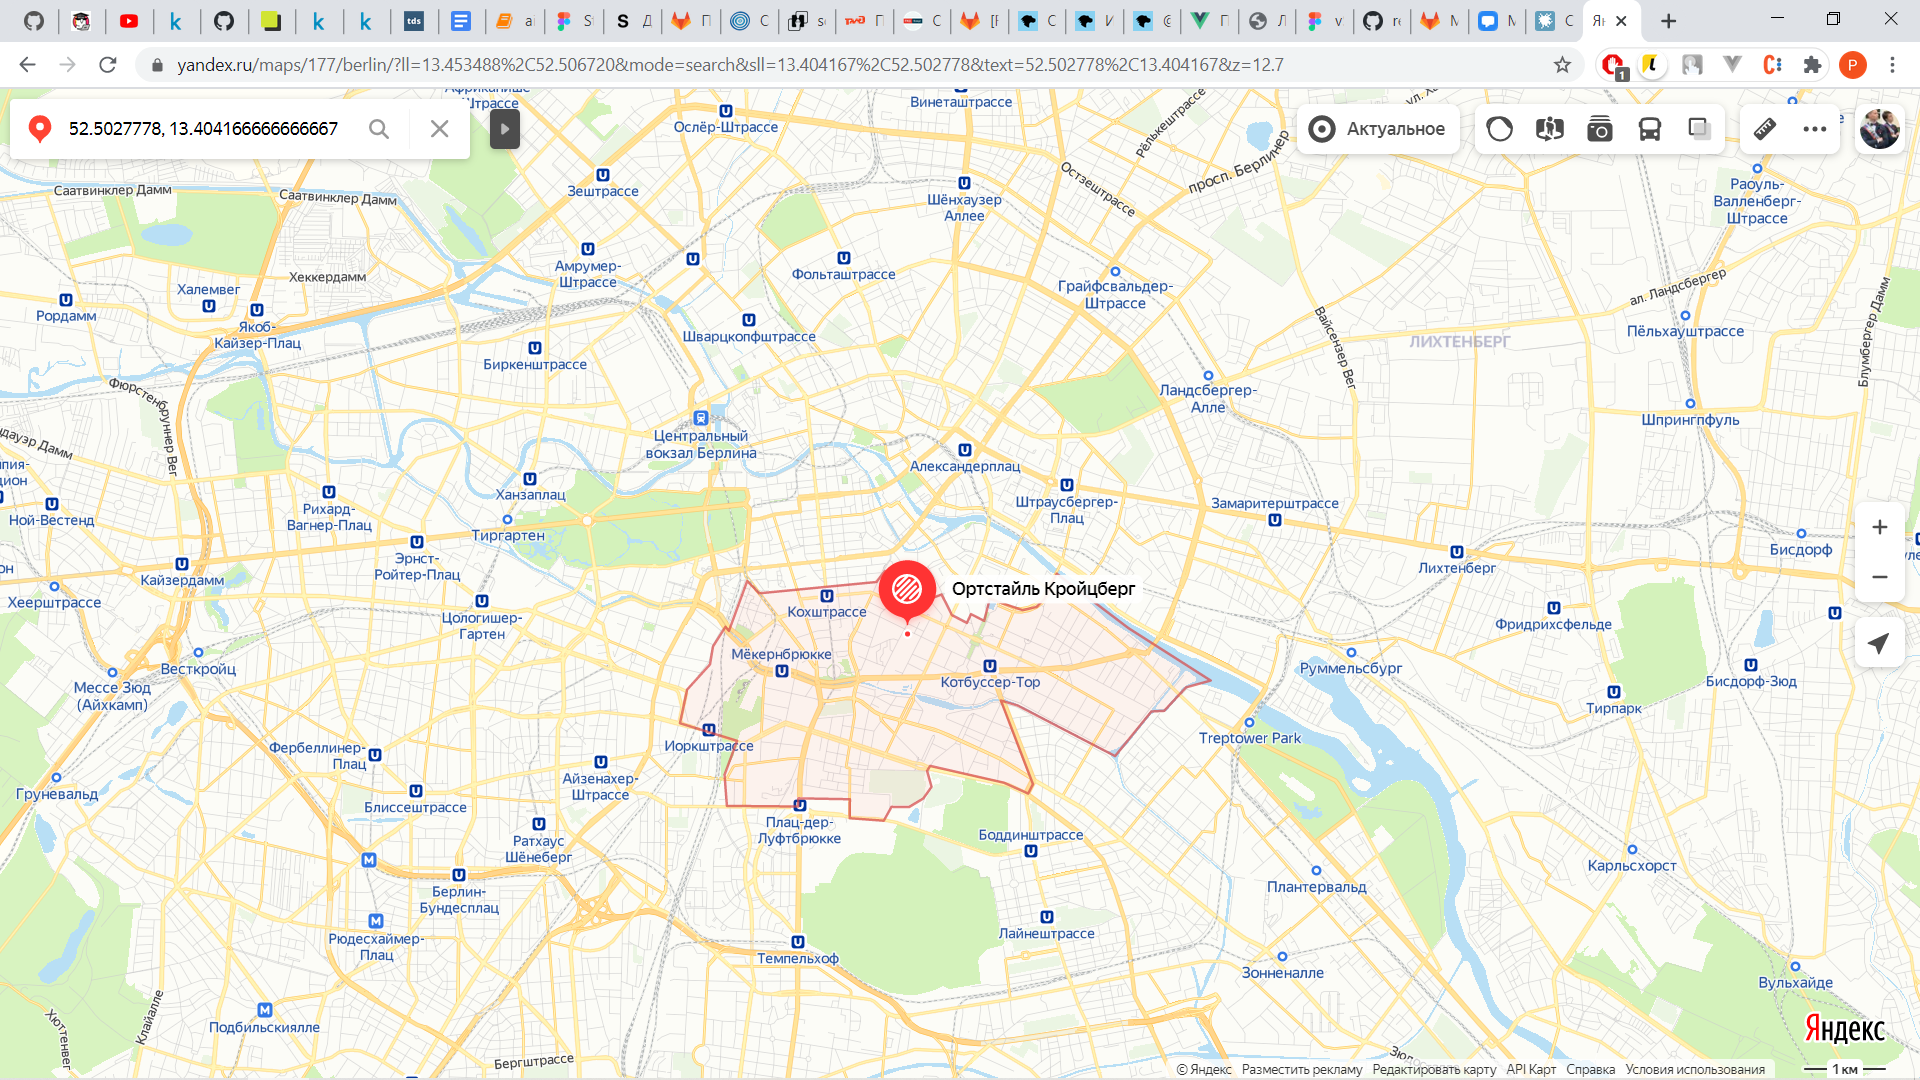

52.5027778, 13.404166666666667- беру данные координаты в качестве центра Берлина.

In [25]:
def distance_to_centre(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

In [26]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_centre(x.latitude, x.longitude), axis=1)

Рассчитали расстояние до центра берлина для каждого из наших наблюдений. Это важно для дальнейшего предсказания цены на аренду.

In [27]:
df_raw.head()

,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,...,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,size,distance
id,,,,,,,,,,,,,,,,,,,,,
2015,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,...,30.0,200.0,28.0,1,4,f,f,strict_14_with_grace_period,75.0,3.533182
2695,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,Real Bed,...,0.0,0.0,0.0,1,2,f,f,flexible,25.0,5.085573
3176,t,Pankow,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,1.0,Real Bed,...,50.0,200.0,20.0,2,62,t,f,strict_14_with_grace_period,68.0,3.695677
3309,t,Tempelhof - Schöneberg,52.498855,13.349065,Apartment,Private room,2,1.0,1.0,Pull-out Sofa,...,30.0,250.0,18.0,1,5,f,f,strict_14_with_grace_period,26.0,3.755285
7071,t,Pankow,52.543157,13.415091,Apartment,Private room,2,1.0,1.0,Real Bed,...,0.0,0.0,24.0,1,2,f,f,moderate,20.0,4.550423


In [28]:
df_raw.isna().sum()

host_has_profile_pic                0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
bed_type                            0
amenities                           0
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
size                            11721
distance                            0
dtype: int64

Теперь нужно заняться заполнением 50! процентов пропущенных значений в поле size. Сделаю это при помощи простой модельки.

Создаем мини- датасет для предикта количества слов в описании к позиции и разбиваем его на тест и трейн подмножества (получилось пополам)

In [29]:
sub_df = df_raw[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']]

In [30]:
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

y_train = train_data['size']

In [31]:
X_train

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance
id,,,,,,,,,
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573
3176,4,1.0,1.0,90.0,50.0,200.0,20.0,2,3.695677
3309,2,1.0,1.0,26.0,30.0,250.0,18.0,1,3.755285
7071,2,1.0,1.0,42.0,0.0,0.0,24.0,1,4.550423
...,...,...,...,...,...,...,...,...,...
29830381,2,0.5,1.0,30.0,25.0,200.0,10.0,1,1.140742
29842909,2,1.0,0.0,100.0,0.0,0.0,0.0,1,1.988263
29846605,4,3.0,2.0,105.0,60.0,0.0,15.0,1,3.025901


Использую линейную регрессию и замеряю время, которое требует модель для обучения.

Пытаюсь подобрать качественную модель для заполнения пропусков.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop('size', axis=1), train_data['size'], test_size=0.33, random_state=42)
reg = linear_model.LinearRegression(n_jobs=-1)
reg.fit(X_train, y_train)
predicted = reg.predict(X_test)
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))
print(mean_squared_error(y_test, predicted))

0.03903514624816595
0.018289673473645185
13548.03886386769


In [38]:
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)
start_time = time.time()
reg = linear_model.LinearRegression(n_jobs=-1)
reg.fit(X_train, train_data['size'])
predicted = reg.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.006957530975341797 seconds ---


In [39]:
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

y_train = train_data['size']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop('size', axis=1), train_data['size'], test_size=0.33, random_state=42)

In [41]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)
print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))
predicted = regr.predict(X_test)
print(mean_squared_error(y_test, predicted))

0.8640740588808646
-0.03317927576718693
14258.33324068711


In [42]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
}
CV_rfc = GridSearchCV(estimator=regr, param_grid=param_grid, cv= 3, n_jobs=-1, verbose=True)
CV_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   34.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [43]:
print(CV_rfc.score(X_train, y_train))
print(CV_rfc.score(X_test, y_test))
predicted = CV_rfc.predict(X_test)
print(mean_squared_error(y_test, predicted))

0.2885409810943852
0.027618515523699202
13419.296697024829


Деревья показали себя немного лучше регрессии (МСЕ меньше на 200), так что использую именно их.

In [44]:
CV_rfc.fit(train_data.drop('size', axis=1), train_data['size'])
predicted = CV_rfc.predict(test_data.drop('size', axis=1))
predicted = pd.DataFrame(predicted)
predicted.columns = ['size']
predicted.head()

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   48.0s finished


,size
0,67.908137
1,110.960306
2,77.654131
3,102.862808
4,67.410928


In [45]:
prelim_index = pd.DataFrame(test_data.drop('size', axis=1).index)
prelim_index.columns = ['prelim']

predicted = pd.concat([predicted, prelim_index], axis=1)
predicted.set_index(['prelim'], inplace=True)
predicted.head()

,size
prelim,
14325,67.908137
20858,110.960306
21869,77.654131
22415,102.862808
28156,67.410928


In [46]:
new_test_data = pd.concat([test_data.drop('size', axis=1), predicted], axis=1)

In [47]:
print(new_test_data.shape)
new_test_data.head()

(11721, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,67.908137
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,110.960306
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,77.654131
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,102.862808
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,67.410928


In [48]:
new_test_data['size'].isna().sum()

0

Замечательно, все пропуски заполнены оптимально.

Сливаю воедино наш тренировочный и тестовый датасеты.

In [49]:
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head()

(22391, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,67.908137
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,110.960306
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,77.654131
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,102.862808
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,67.410928


Слил воедино весь датасет, теперь уже с заполненными пропусками.

In [50]:
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)

df = pd.concat([sub_df_new, df_raw], axis=1)

print(df.shape)
df.head()

(22391, 22)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,...,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0,...,52.534537,13.402557,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",4,f,f,strict_14_with_grace_period
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0,...,52.548513,13.404553,Apartment,Private room,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",2,f,f,flexible
3176,4,1.0,1.0,90.0,50.0,200.0,20.0,2,3.695677,68.0,...,52.534996,13.417579,Apartment,Entire home/apt,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",62,t,f,strict_14_with_grace_period
3309,2,1.0,1.0,26.0,30.0,250.0,18.0,1,3.755285,26.0,...,52.498855,13.349065,Apartment,Private room,Pull-out Sofa,"{Internet,Wifi,""Pets allowed"",""Pets live on th...",5,f,f,strict_14_with_grace_period
7071,2,1.0,1.0,42.0,0.0,0.0,24.0,1,4.550423,20.0,...,52.543157,13.415091,Apartment,Private room,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",2,f,f,moderate


In [51]:
df.isna().sum()

accommodates                    0
bathrooms                       0
bedrooms                        0
price                           0
cleaning_fee                    0
security_deposit                0
extra_people                    0
guests_included                 0
distance                        0
size                            0
host_has_profile_pic            0
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
bed_type                        0
amenities                       0
minimum_nights                  0
instant_bookable                0
is_business_travel_ready        0
cancellation_policy             0
dtype: int64

Теперь пропусков в данных нет. Замечательно!

In [52]:
df.describe()

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,latitude,longitude,minimum_nights
count,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000,22391.000000
mean,2.626055,1.090416,1.156179,57.587245,18.119646,117.151132,8.253673,1.327900,4.547464,60.309819,52.509824,13.406225,7.168907
std,1.471965,0.322431,0.629371,42.193976,24.689926,299.339020,11.099403,0.816494,2.661159,80.845642,0.030844,0.057908,40.794753
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.198956,0.000000,52.346203,13.103557,1.000000
25%,2.000000,1.000000,1.000000,30.000000,0.000000,0.000000,0.000000,1.000000,2.979687,25.000000,52.489015,13.375651,2.000000
50%,2.000000,1.000000,1.000000,45.000000,10.000000,0.000000,5.000000,1.000000,4.088758,49.097377,52.509081,13.416881,2.000000
75%,3.000000,1.000000,1.000000,70.000000,30.000000,150.000000,15.000000,1.000000,5.551307,66.108955,52.532697,13.439319,4.000000
max,16.000000,8.500000,9.000000,400.000000,450.000000,4280.000000,250.000000,16.000000,25.012109,980.000000,52.651670,13.757642,5000.000000


In [53]:
df['size'].describe()

count    22391.000000
mean        60.309819
std         80.845642
min          0.000000
25%         25.000000
50%         49.097377
75%         66.108955
max        980.000000
Name: size, dtype: float64

Есть большие выбросы в сторону большого размера. Возможно, стоит их почистить.

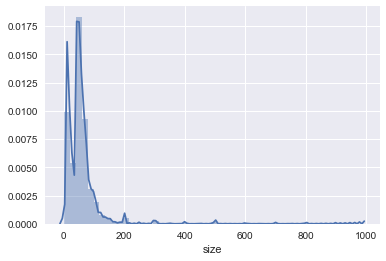

In [54]:
sns_plot = sns.distplot(df['size'])
fig = sns_plot.get_figure()

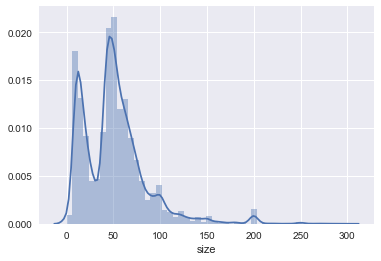

In [55]:
sns_plot = sns.distplot(df['size'][df['size']<300])
fig = sns_plot.get_figure()

Вот так картина выглядит намного лучше. Все, что справо- очевидно, обрезаю. Осталось посмотреть, сколько у нас size == 0

In [56]:
df['size'][df['size']==0].count()

120

120 наблюдений- многовато, их тоже стоит удалить из выборки.

In [57]:
df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)

In [58]:
df.shape

(21958, 22)

Надо что то делать с  Amenities (Удобства). Снова подглядываю в notebook старшего товарища и нахожу интересное решение.

In [59]:
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[('Wifi', 20952),
 ('Kitchen', 20809),
 ('Heating', 20657),
 ('Essentials', 19811),
 ('Washer', 18071),
 ('Hair dryer', 14474),
 ('Laptop friendly workspace', 14095),
 ('Hangers', 13514),
 ('Iron', 10876),
 ('Shampoo', 10339),
 ('TV', 9778),
 ('Hot water', 9421),
 ('Family/kid friendly', 7925),
 ('Internet', 7699),
 ('Host greets you', 6469),
 ('Smoke detector', 6245),
 ('Buzzer/wireless intercom', 5963),
 ('Lock on bedroom door', 5138),
 ('Free street parking', 5037),
 ('Refrigerator', 5033),
 ('Dishes and silverware', 4909),
 ('Elevator', 4703),
 ('Cooking basics', 4673),
 ('Bed linens', 4656),
 ('Stove', 4655),
 ('Smoking allowed', 4509),
 ('Oven', 4161),
 ('translation missing: en.hosting_amenity_50', 4095),
 ('First aid kit', 3866),
 ('Cable TV', 3577)]

In [60]:
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

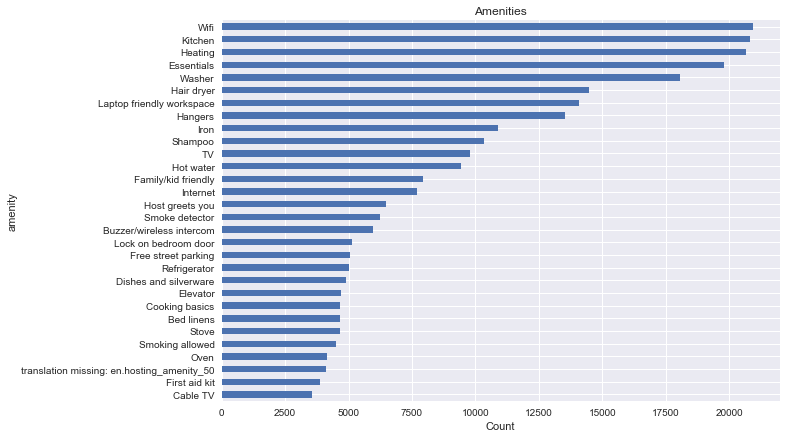

In [61]:
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False,
                                                      title='Amenities')
plt.xlabel('Count');

In [62]:
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')
df.drop(['amenities'], axis=1, inplace=True)

In [63]:
df.head()

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,...,bed_type,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0,...,Real Bed,4,f,f,strict_14_with_grace_period,True,True,True,False,False
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0,...,Real Bed,2,f,f,flexible,True,False,False,False,False
3176,4,1.0,1.0,90.0,50.0,200.0,20.0,2,3.695677,68.0,...,Real Bed,62,t,f,strict_14_with_grace_period,True,False,True,False,False
3309,2,1.0,1.0,26.0,30.0,250.0,18.0,1,3.755285,26.0,...,Pull-out Sofa,5,f,f,strict_14_with_grace_period,True,False,False,True,False
7071,2,1.0,1.0,42.0,0.0,0.0,24.0,1,4.550423,20.0,...,Real Bed,2,f,f,moderate,True,False,True,False,False


Строим распределение цен относительно долготы и широты.

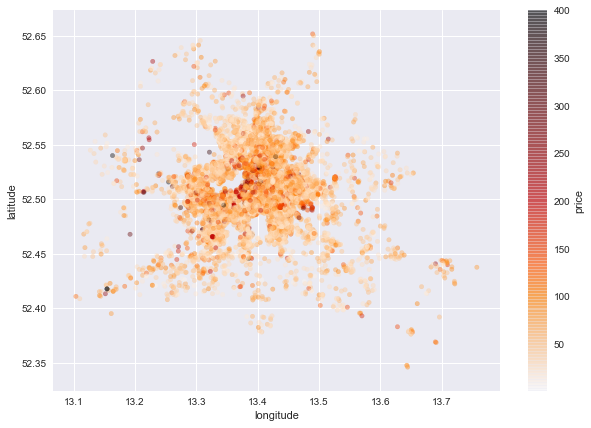

In [64]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

Смотрю, как взаимосвязаны средняя цена и расстояние до центра Берлина

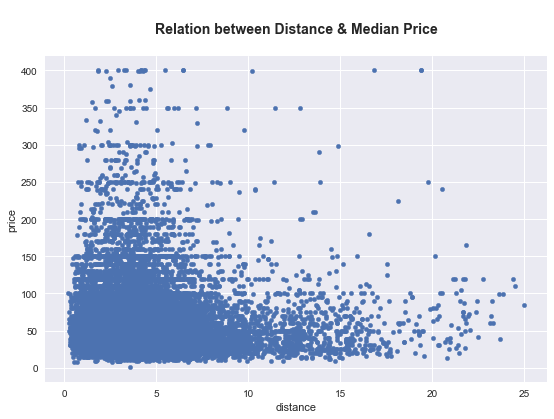

In [65]:
df.plot.scatter(x="distance", y="price", figsize=(9,6),)
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

Смотрю соотношение цены и площади арендуемого жилья.

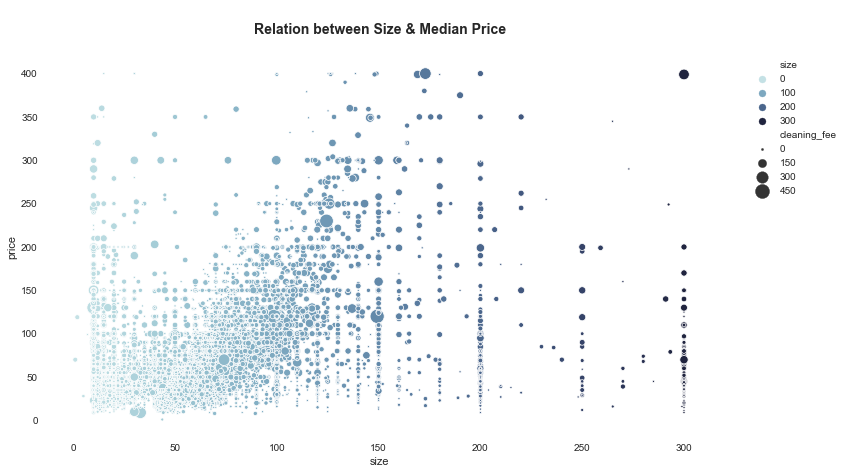

In [66]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df)

plt.title('\nRelation between Size & Median Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Как можно увидеть на графике ниже- цена за аренду растет вместе со строгостью отмены и возврата за нее денег.

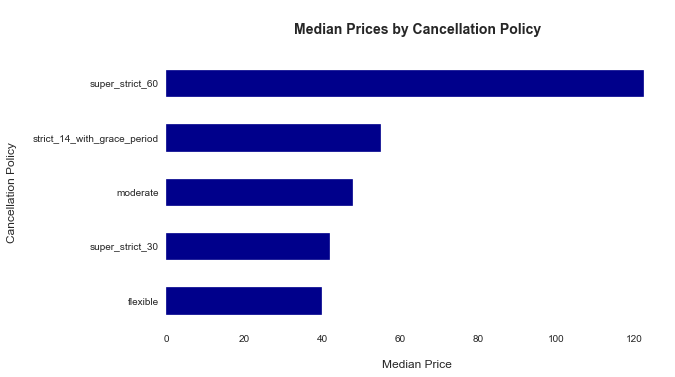

In [67]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');

Выбрасываю уже не нужные долготу и широту. Вместо них у нас расстояние до центра Берлина. 'neighbourhood_group_cleansed', 'property_type' тоже посчитал ненужными.

In [68]:
df.head()

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,...,bed_type,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0,...,Real Bed,4,f,f,strict_14_with_grace_period,True,True,True,False,False
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0,...,Real Bed,2,f,f,flexible,True,False,False,False,False
3176,4,1.0,1.0,90.0,50.0,200.0,20.0,2,3.695677,68.0,...,Real Bed,62,t,f,strict_14_with_grace_period,True,False,True,False,False
3309,2,1.0,1.0,26.0,30.0,250.0,18.0,1,3.755285,26.0,...,Pull-out Sofa,5,f,f,strict_14_with_grace_period,True,False,False,True,False
7071,2,1.0,1.0,42.0,0.0,0.0,24.0,1,4.550423,20.0,...,Real Bed,2,f,f,moderate,True,False,True,False,False


In [69]:
df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed', 'property_type'], axis=1, inplace=True)
df.corr()

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed
accommodates,1.000000,0.241349,0.622652,0.574710,0.354820,0.117548,0.245309,0.506920,0.056073,0.312107,0.000464,0.062378,0.240839,0.346485,0.020419,-0.103398
bathrooms,0.241349,1.000000,0.303616,0.251768,0.138911,0.052009,0.060460,0.169720,0.022513,0.188708,-0.004453,0.026151,0.080188,0.075631,0.000991,-0.014273
bedrooms,0.622652,0.303616,1.000000,0.470955,0.275837,0.113686,0.140686,0.373783,0.048639,0.259375,0.005613,0.050801,0.150932,0.259330,0.019750,-0.089857
price,0.574710,0.251768,0.470955,1.000000,0.404495,0.180817,0.192834,0.412379,-0.064924,0.388248,0.022815,0.083377,0.269390,0.231905,0.045204,-0.151322
cleaning_fee,0.354820,0.138911,0.275837,0.404495,1.000000,0.422598,0.256327,0.293532,0.000663,0.280403,0.107037,0.117754,0.236729,0.193089,0.115873,-0.155521
security_deposit,0.117548,0.052009,0.113686,0.180817,0.422598,1.000000,0.123627,0.098442,-0.010850,0.153197,0.132140,0.043523,0.114261,0.085888,0.060026,-0.091715
extra_people,0.245309,0.060460,0.140686,0.192834,0.256327,0.123627,1.000000,0.328268,0.002399,0.156598,-0.012508,0.078011,0.090935,0.143877,0.134283,-0.044829
guests_included,0.506920,0.169720,0.373783,0.412379,0.293532,0.098442,0.328268,1.000000,0.014063,0.213682,0.009763,0.050028,0.157655,0.223711,0.043117,-0.081025
distance,0.056073,0.022513,0.048639,-0.064924,0.000663,-0.010850,0.002399,0.014063,1.000000,-0.084531,0.004871,0.016908,0.127579,0.038632,0.044422,-0.050627
size,0.312107,0.188708,0.259375,0.388248,0.280403,0.153197,0.156598,0.213682,-0.084531,1.000000,0.016694,0.057571,0.161490,0.140417,0.026614,-0.087773


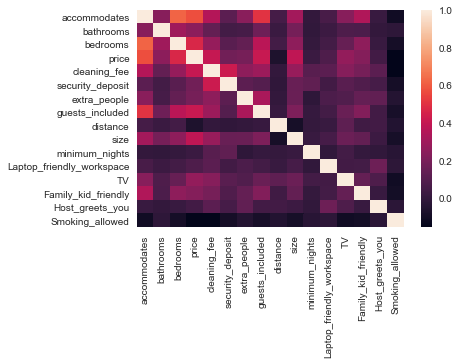

In [70]:
sns.heatmap(df.corr())

Делаю 'host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy' категориальными

In [71]:
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df[col] = df[col].astype('category')

Выношу в отдельную переменную нашу целевую переменную

In [72]:
target = df[["price"]]
features = df.drop(["price"], axis=1)

Далее- все категориальные переменные делаю дамми-переменными.

In [73]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

И наконец сливаю все воедино. На этом предобработка даных завершена.

In [74]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [75]:
print(features_recoded.shape)
features_recoded.head()

(21958, 33)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,...,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
2015,3,1.0,1.0,30.0,200.0,28.0,1,3.533182,75.0,4,...,0,1,1,0,1,0,0,1,0,0
2695,2,1.0,1.0,0.0,0.0,0.0,1,5.085573,25.0,2,...,0,1,1,0,1,1,0,0,0,0
3176,4,1.0,1.0,50.0,200.0,20.0,2,3.695677,68.0,62,...,0,1,0,1,1,0,0,1,0,0
3309,2,1.0,1.0,30.0,250.0,18.0,1,3.755285,26.0,5,...,1,0,1,0,1,0,0,1,0,0
7071,2,1.0,1.0,0.0,0.0,24.0,1,4.550423,20.0,2,...,0,1,1,0,1,0,1,0,0,0


Далее- модельки!

Разбиваю датасет

In [76]:
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

Стандартизирую трейн и тест
Standardize features by removing the mean and scaling to unit variance

The standard score of a sample x is calculated as:

z = (x - u) / s

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

На гриде нахожу оптимальные параметры для буста

In [ ]:
booster = xgb.XGBRegressor()

In [316]:
param_grid = {'n_estimators': [100, 150, 200, 250],
              'learning_rate': [0.01, 0.05, 0.1, 0.2], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2, 0.25]}

booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1, verbose=True)

booster_grid_search.fit(X_train, y_train)

print(booster_grid_search.best_params_)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 30.5min finished


{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250}


{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250}

Обучаю модель на оптимальных параметрах

In [320]:
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, 
                           max_depth=7, n_estimators=250)

booster.fit(X_train, y_train)

y_pred_test = booster.predict(X_test)

In [185]:
X_train.head()

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance
id,,,,,,,,,
20508256,2,1.0,1.0,40.0,0.0,0.0,0.0,1,2.976668
17577653,5,1.0,2.0,53.0,75.0,500.0,5.0,2,5.898195
11569258,1,1.0,1.0,12.0,0.0,0.0,0.0,1,5.657288
1302932,2,1.0,1.0,85.0,38.0,200.0,5.0,1,2.426736
7261815,2,1.0,1.0,40.0,0.0,150.0,0.0,1,4.734556


И последнее- смотрю метрики качества, которыми остаюсь вполне доволен.

In [324]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {RMSE}")

RMSE: 24.38973787287129


In [325]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {r2}")

r2: 0.6850409231560087


In [330]:
best_RMSE = 999999
best_r2 = 0
id_RMSE = 0
id_r2 = 0
best_id = 0
for i in range(1,70):
    booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, 
                           max_depth=7, n_estimators=250, random_state=i)
    booster.fit(X_train, y_train)
    y_pred_test = booster.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE and  best_r2 < r2:
        best_id = i
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        id_RMSE = i
    if best_r2 < r2:
        best_r2 = r2
        id_r2 = i

In [335]:
print("Best RMSE: {} best RMSE id: {} best r2: {} best r2 id: {}, best_id: {}"
      .format(best_RMSE, id_RMSE, best_r2, id_r2, best_id))

Best RMSE: 24.27973466986772 best RMSE id: 4 best r2: 0.6878755887582568 best r2 id: 4, best_id: 4


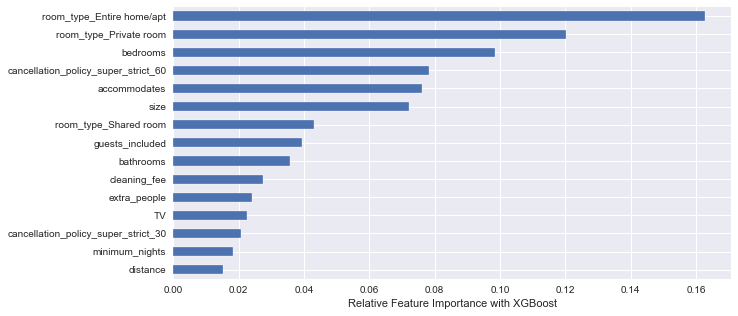

In [333]:
feat_importances = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');

In [123]:
features_recoded.head()

,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,...,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
2015,3,1.0,1.0,30.0,200.0,28.0,1,3.533182,75.0,4,...,0,1,1,0,1,0,0,1,0,0
2695,2,1.0,1.0,0.0,0.0,0.0,1,5.085573,25.0,2,...,0,1,1,0,1,1,0,0,0,0
3176,4,1.0,1.0,50.0,200.0,20.0,2,3.695677,68.0,62,...,0,1,0,1,1,0,0,1,0,0
3309,2,1.0,1.0,30.0,250.0,18.0,1,3.755285,26.0,5,...,1,0,1,0,1,0,0,1,0,0
7071,2,1.0,1.0,0.0,0.0,24.0,1,4.550423,20.0,2,...,0,1,1,0,1,0,1,0,0,0


Как оказалось, мучения с расстоянием от центра Берлина оказались напрасны. А вот дамми-переменные внесли в модель наибольшие корректировки.

К следующей лабе сделаю то же самое, но уже со случайным лесом и гридом из sklearn.

Что касается анализа выше- notebook, с которого я брал пример выбил RMSE: 23.6884 r2: 0.6718. так что у меня не все так плохо.

Пробую то же самое случайным лесом

In [197]:
rfreereg = RandomForestRegressor(n_jobs=-1)
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [2,3,4,5,6,7,8],
    'min_samples_split': [3,5,7,9],
    'max_features': ['auto', 'sqrt', 'log2']
}
rfreereg_grid_search = GridSearchCV(rfreereg, param_grid, cv=3, n_jobs=-1, verbose=True)

rfreereg_grid_search.fit(X_train, y_train)

print(rfreereg_grid_search.best_params_)

Fitting 3 folds for each of 336 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed:  8.4min finished


{'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 3, 'n_estimators': 200}


In [198]:
rfreereg = RandomForestRegressor(max_depth=8, n_estimators=200, min_samples_split=3, max_features='auto')

rfreereg.fit(X_train, y_train)

y_pred_test = rfreereg.predict(X_test)

In [199]:
X_train

,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,...,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
19280585,2,1.0,0.0,0.0,750.0,0.0,1,9.780625,61.122861,2,...,1,0,0,1,1,1,0,0,0,0
23663558,2,1.0,1.0,18.0,90.0,10.0,1,2.552884,43.199153,5,...,0,1,0,1,1,1,0,0,0,0
3561704,2,1.0,0.0,0.0,0.0,0.0,1,3.740630,10.000000,14,...,0,1,1,0,1,0,1,0,0,0
15124115,2,1.0,1.0,0.0,200.0,0.0,1,4.748608,22.000000,1,...,0,1,1,0,1,0,0,1,0,0
1509828,2,1.0,1.0,0.0,0.0,0.0,1,3.323565,43.896692,5,...,0,1,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23819602,1,1.0,0.0,0.0,0.0,0.0,1,6.519201,20.000000,3,...,0,1,1,0,1,1,0,0,0,0
9528288,2,1.0,1.0,0.0,200.0,15.0,2,6.311503,46.000000,7,...,0,1,1,0,1,0,0,1,0,0
13249729,2,1.0,1.0,0.0,0.0,0.0,1,4.166277,10.000000,1,...,0,1,1,0,1,1,0,0,0,0
7567076,2,1.0,1.0,10.0,0.0,20.0,1,3.031703,10.000000,5,...,0,1,0,1,1,0,1,0,0,0


In [200]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {RMSE}")

RMSE: 25.73603752064931


In [201]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {r2}")

r2: 0.6022732940152143


In [202]:
best_RMSE = 999999
best_r2 = 0
id_RMSE = 0
id_r2 = 0
best_id = 0
for i in range(1,70):
    rfreereg = RandomForestRegressor(max_depth=8, n_estimators=200, min_samples_split=3, max_features='sqrt', random_state=i)
    
    rfreereg.fit(X_train, y_train)
    y_pred_test = rfreereg.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE and  best_r2 < r2:
        best_id = i
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        id_RMSE = i
    if best_r2 < r2:
        best_r2 = r2
        id_r2 = i

In [203]:
print("Best RMSE: {} best RMSE id: {} best r2: {} best r2 id: {}, best_id: {}"
      .format(best_RMSE, id_RMSE, best_r2, id_r2, best_id))

Best RMSE: 26.481532043667755 best RMSE id: 59 best r2: 0.5788977082629585 best r2 id: 59, best_id: 59


Как мы видим, по обеим метрикам качества проигрывает случайный лес и довольно существенно. Так что лучшим буду считать хгбуст.

Пробую теперь PCA

In [94]:
pca = PCA(n_components=10)
new_features = StandardScaler().fit_transform(features_recoded)
new_features = pca.fit_transform(new_features)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.12828404 0.06680525 0.06279309 0.06020592 0.05161766 0.04771499
 0.04478812 0.03586401 0.03556877 0.0333258 ]
[300.23249078 216.65897136 210.05224102 205.67948124 190.44541809
 183.10439973 177.39966019 158.74526233 158.09050634 153.02475682]


Разбиваю новый, преобразованный датасет на тест и трейн

In [96]:
X_train, X_test, y_train, y_test = train_test_split(new_features, target, test_size=0.2)

Перебираю различное количество компонент, останавливаюсь на 5

In [102]:
for i in range(1,15):
    pca = PCA(n_components=i)
    new_features = StandardScaler().fit_transform(features_recoded)
    new_features = pca.fit_transform(new_features)
    
    X_train, X_test, y_train, y_test = train_test_split(new_features, target, test_size=0.2)
    best_RMSE = 999999
    best_r2 = 0
    
    rfreereg = RandomForestRegressor(max_depth=8, n_estimators=200, min_samples_split=3, max_features='sqrt')

    rfreereg.fit(X_train, y_train)
    y_pred_test = rfreereg.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE:
        best_RMSE = RMSE
    if best_r2 < r2:
        best_r2 = r2
    print("RMSE: {} r2: {} PCA_num: {}".format(best_RMSE, best_r2, i))

RMSE: 30.54693809754555 r2: 0.42158831190572776 PCA_num: 1
RMSE: 30.69561763159924 r2: 0.46066978424898 PCA_num: 2
RMSE: 31.846421784307992 r2: 0.45146295067057063 PCA_num: 3
RMSE: 31.511031261595825 r2: 0.4530244606401431 PCA_num: 4
RMSE: 31.374953435330667 r2: 0.47324684096220715 PCA_num: 5
RMSE: 29.440546484767864 r2: 0.4710015915279443 PCA_num: 6
RMSE: 30.32982447854872 r2: 0.46030360362356326 PCA_num: 7
RMSE: 29.746995127254376 r2: 0.5119557203510996 PCA_num: 8
RMSE: 30.833373936918708 r2: 0.4931542302706574 PCA_num: 9
RMSE: 30.25441190116725 r2: 0.4986512927947291 PCA_num: 10
RMSE: 29.18734995676638 r2: 0.49592211590337487 PCA_num: 11
RMSE: 31.168144899600694 r2: 0.49176872904252245 PCA_num: 12
RMSE: 29.959529622133264 r2: 0.5258811874614711 PCA_num: 13
RMSE: 28.356368264984198 r2: 0.5088582733805931 PCA_num: 14


In [100]:
print("RMSE: {} r2: {} PCA_num: {}"
      .format(best_RMSE, best_r2, i))

Best RMSE: 30.500592336185658 best RMSE id: 1 best r2: 0.4605023211678433 best r2 id: 1, best_id: 1


In [103]:
pca = PCA(n_components=5)
new_features = StandardScaler().fit_transform(features_recoded)
new_features = pca.fit_transform(new_features)

In [119]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
print(pca.singular_values_)
print(pca.explained_variance_ratio_.sum())

[0.12828382 0.0667783  0.06274293 0.06017007 0.05151314]
[4.10526919 2.13700283 2.00786515 1.92552983 1.64849571]
[300.23223606 216.61526078 209.96831934 205.61823461 190.2525172 ]
0.36948825683580633


Тут видно, что не очень то они и хорошо объясняют искодный датасет

In [104]:
X_train, X_test, y_train, y_test = train_test_split(new_features, target, test_size=0.2)

In [105]:
rfreereg = RandomForestRegressor(n_jobs=-1)
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [2,3,4,5,6,7,8],
    'min_samples_split': [3,5,7,9],
    'max_features': ['auto', 'sqrt', 'log2']
}
rfreereg_grid_search = GridSearchCV(rfreereg, param_grid, cv=3, n_jobs=-1, verbose=True)

rfreereg_grid_search.fit(X_train, y_train)

print(rfreereg_grid_search.best_params_)

Fitting 3 folds for each of 336 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed: 10.0min finished


{'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 7, 'n_estimators': 200}


Перебрал на гриде, дальше буду использовать лучшую модель

In [109]:
rfreereg = RandomForestRegressor(max_depth=8, n_estimators=200, min_samples_split=7, max_features='log2', n_jobs=-1)

rfreereg.fit(X_train, y_train)
y_pred_test = rfreereg.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2 = r2_score(y_test, y_pred_test)

print("RMSE: {} r2: {}".format(RMSE, r2))

RMSE: 30.272741674637757 r2: 0.4828897909524277


Модель лишь ухудшилась. Попробую выбить из нее результаты получше, задавая рандом

In [113]:
best_RMSE = 999999
best_r2 = 0
best_RMSE_i = 0
best_r2_i = 0

for i in range(1,50):
    
    rfreereg = RandomForestRegressor(max_depth=8, n_estimators=200, min_samples_split=7, max_features='log2', n_jobs=-1,  random_state=i)

    rfreereg.fit(X_train, y_train)
    y_pred_test = rfreereg.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        best_RMSE_i = i
    if best_r2 < r2:
        best_r2 = r2
        best_r2_i = i

In [114]:
print("RMSE: {} best_RMSE_i: {} r2: {} best_r2_i: {} PCA_num: 5".format(best_RMSE, best_RMSE_i, best_r2, best_r2_i))

RMSE: 30.24275087438169 best_RMSE_i: 34 r2: 0.4839138717641688 best_r2_i: 34 PCA_num: 5


А вот и максимум нашей модели. Не очень.

In [120]:
print(rfreereg.feature_importances_)

[0.65630207 0.06553377 0.13664002 0.06880903 0.07271511]


Минус PCA- влияние тех или иных фич на нашу модель теперь обезличено.

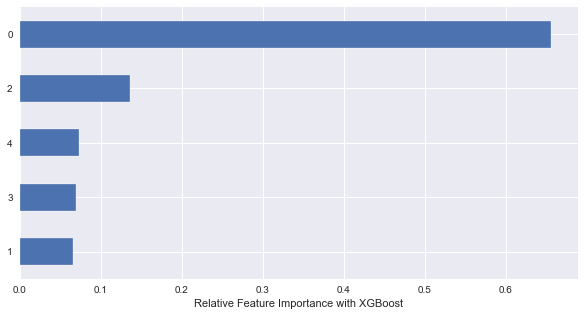

In [122]:
feat_importances = pd.Series(rfreereg.feature_importances_)
feat_importances.nlargest(15).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');

Ниже- попытка выбрасывать вручную наши фичи, вносящие малый вклад в модель.

In [141]:
drop_lst = [ 'distance', 'minimum_nights', 'cancellation_policy_super_strict_30', 'TV','extra_people', 'cleaning_fee']

In [142]:
best_RMSE = 999999
best_r2 = 0
id_RMSE = 0
id_r2 = 0
best_id = 0
k = 0
hand_features_recoded = features_recoded.copy()

for i in drop_lst:
    k+=1
    hand_features_recoded = hand_features_recoded.drop(i, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(hand_features_recoded, target, test_size=0.2)
    
    rfreereg = RandomForestRegressor(max_depth=8, n_estimators=200, min_samples_split=3, max_features='sqrt')

    rfreereg.fit(X_train, y_train)
    y_pred_test = rfreereg.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        id_RMSE = k
    if best_r2 < r2:
        best_r2 = r2
        id_r2 = k
    print("RMSE: {}, r2: {}, колонка на выброс: {}".format(RMSE, r2, i))
    
print("RMSE: {} best_RMSE: {} r2: {} best_r2: {}".format(best_RMSE, id_RMSE, best_r2, id_r2))

RMSE: 26.589824741946128, r2: 0.5768257160162109, колонка на выброс: distance
RMSE: 26.032603413990273, r2: 0.5866644728149711, колонка на выброс: minimum_nights
RMSE: 28.049402318699578, r2: 0.5697474130033838, колонка на выброс: cancellation_policy_super_strict_30
RMSE: 25.844359821132574, r2: 0.594032107119387, колонка на выброс: TV
RMSE: 28.202205050807212, r2: 0.5653034133360402, колонка на выброс: extra_people
RMSE: 28.306451838300188, r2: 0.536776126121803, колонка на выброс: cleaning_fee
RMSE: 25.844359821132574 best_RMSE: 4 r2: 0.594032107119387 best_r2: 4


In [146]:
drop_lst = [ 'distance', 'TV', 'minimum_nights']
best_RMSE = 999999
best_r2 = 0
id_RMSE = 0
id_r2 = 0
best_id = 0
k = 0
hand_features_recoded = features_recoded.copy()

for i in drop_lst:
    k+=1
    hand_features_recoded = hand_features_recoded.drop(i, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(hand_features_recoded, target, test_size=0.2)
    
    rfreereg = RandomForestRegressor(max_depth=8, n_estimators=200, min_samples_split=3, max_features='sqrt')

    rfreereg.fit(X_train, y_train)
    y_pred_test = rfreereg.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE:
        best_RMSE = RMSE
        id_RMSE = k
    if best_r2 < r2:
        best_r2 = r2
        id_r2 = k
    print("RMSE: {}, r2: {}, колонка на выброс: {}".format(RMSE, r2, i))
    
print("RMSE: {} best_RMSE: {} r2: {} best_r2: {}".format(best_RMSE, id_RMSE, best_r2, id_r2))

RMSE: 24.175734055093287, r2: 0.6112126409723664, колонка на выброс: distance
RMSE: 29.01439461748728, r2: 0.5317006800632531, колонка на выброс: TV
RMSE: 28.324857720859217, r2: 0.5602555769571405, колонка на выброс: minimum_nights
RMSE: 24.175734055093287 best_RMSE: 1 r2: 0.6112126409723664 best_r2: 1


По итогу лучшее, что получилось сделать с ручным выкидыванием маловажных фич- RMSE: 24.175734055093287, r2: 0.6112126409723664, колонка на выброс: distance